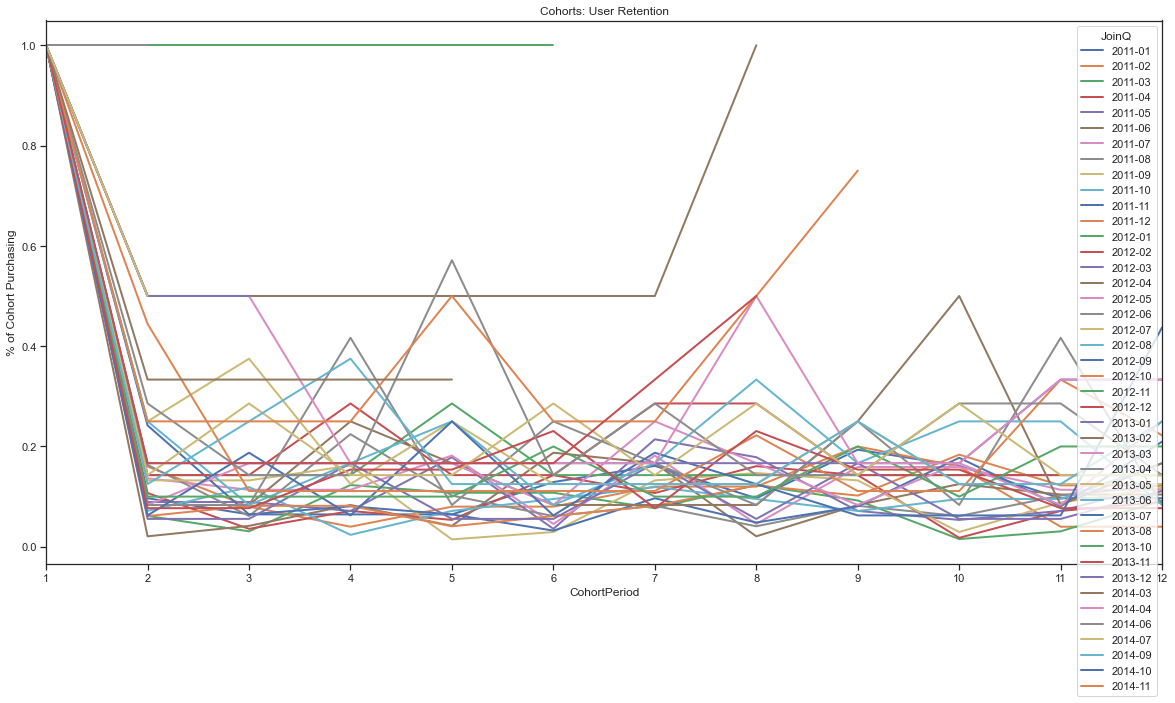

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from datetime import datetime, timedelta
import math

def get_quarter(d):
    return "Q%d_%d" % (math.ceil(d.month/3), d.year)


pd.set_option('max_columns', 50)
mpl.rcParams['lines.linewidth'] = 2

# это чтобы графики строились непосредственно в блокноте iPython
%matplotlib inline 

df = pd.read_excel('Superstore.xlsx')
# Добавим столбец OrderPeriod для дальнейшей группировки данных
df['OrderPeriod'] = df.OrderDate.apply(lambda x: x.strftime('%Y-%m'))
df.set_index('CustomerID', inplace=True) #добавим индекс в dataFrame по ClientID

df['JoinQ'] = df.groupby(level=0)['OrderDate'].min().apply(lambda x: x.strftime('%Y-%m')) #добавим столбец JoinMonth
df.reset_index(inplace=True) #переиндексируем df

df.insert(len(df.columns), "TotalOrders", 0, allow_duplicates=False) #создадим столбец в котором далее поместим количество заказов

#свернем данные в когорты
grouped = df.groupby(['JoinQ', 'OrderPeriod'])

# количество уникальных пользователей и общее количество заказов и выручка за период
cohorts = grouped.agg({'CustomerID': pd.Series.nunique,
                       'TotalOrders': pd.Series.count, 
                       'Sales': np.sum})

# переименуем некоторые столбцы для большего понимания
cohorts.rename(columns={'CustomerID': 'TotalUsers',
                        'TotalOrders': 'TotalOrders'}, inplace=True)

# добавим ярлык для периодов
def cohort_period(df):
    df['CohortPeriod'] = np.arange(len(df)) + 1
    return df

cohorts = cohorts.groupby(level=0).apply(cohort_period)

#посчитаем retention

# переиндексируем DataFrame
cohorts.reset_index(inplace=True)
cohorts.set_index(['JoinQ','CohortPeriod'], inplace=True)

# создадим ряд содержаший размер каждой когорты JoinMonth
cohort_group_size = cohorts['TotalUsers'].groupby(level=0).first()
cohorts['TotalUsers'].unstack(0)
user_retention = cohorts['TotalUsers'].unstack(0).divide(cohort_group_size, axis=1)



user_retention[['2011-01',
 '2011-02',
 '2011-03',
 '2011-04',
 '2011-05',
 '2011-06',
 '2011-07',
 '2011-08',
 '2011-09',
 '2011-10',
 '2011-11',
 '2011-12',
 '2012-01',
 '2012-02',
 '2012-03',
 '2012-04',
 '2012-05',
 '2012-06',
 '2012-07',
 '2012-08',
 '2012-09',
 '2012-10',
 '2012-11',
 '2012-12',
 '2013-01',
 '2013-02',
 '2013-03',
 '2013-04',
 '2013-05',
 '2013-06',
 '2013-07',
 '2013-08',
 '2013-10',
 '2013-11',
 '2013-12',
 '2014-03',
 '2014-04',
 '2014-06',
 '2014-07',
 '2014-09',
 '2014-10',
 '2014-11']].plot(figsize=(20,10))
plt.title('Cohorts: User Retention')
plt.xticks(np.arange(1, 12.1, 1)) # разбивка оси X
plt.xlim(1, 12) #ось X
plt.ylabel('% of Cohort Purchasing');



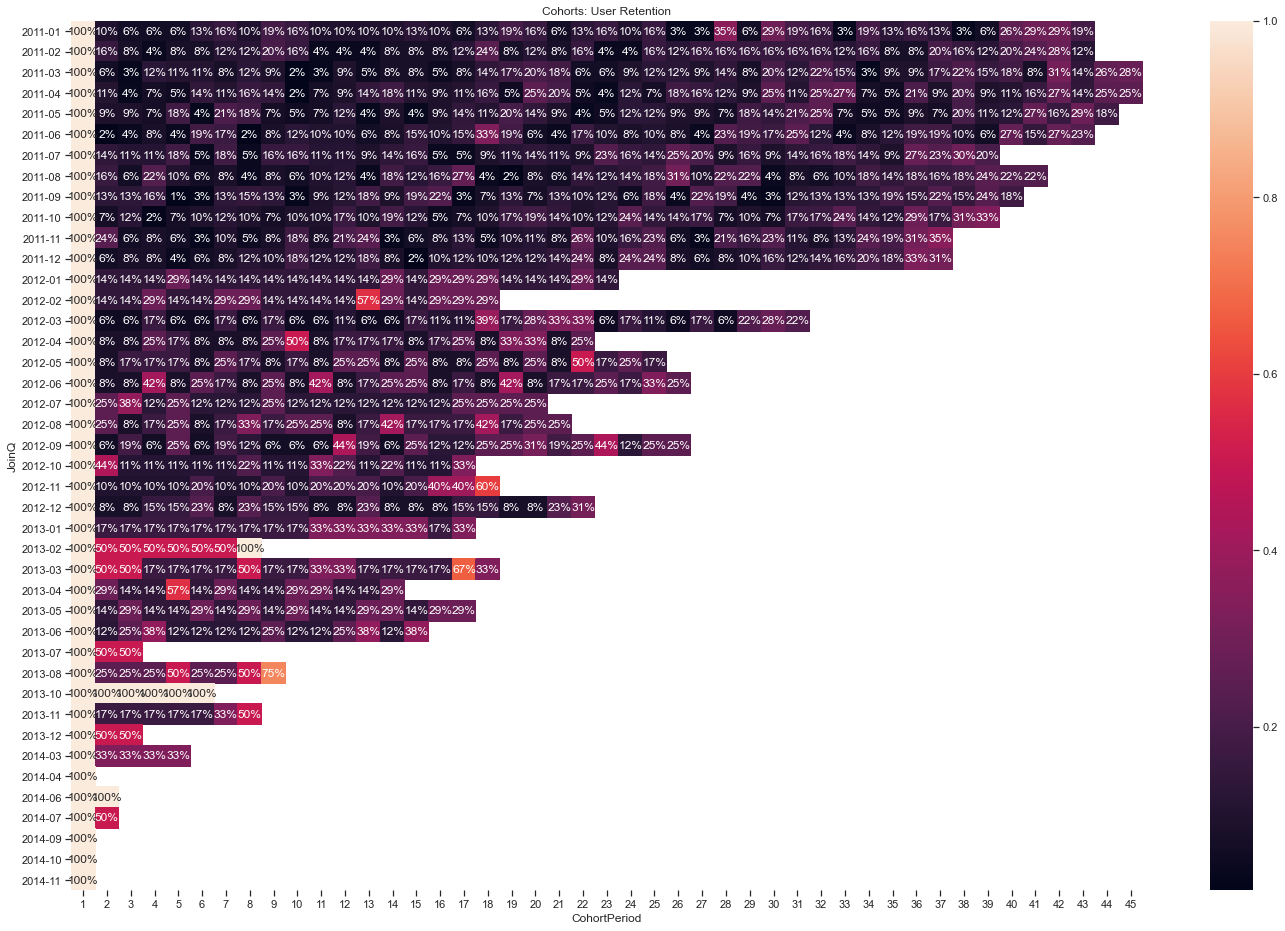

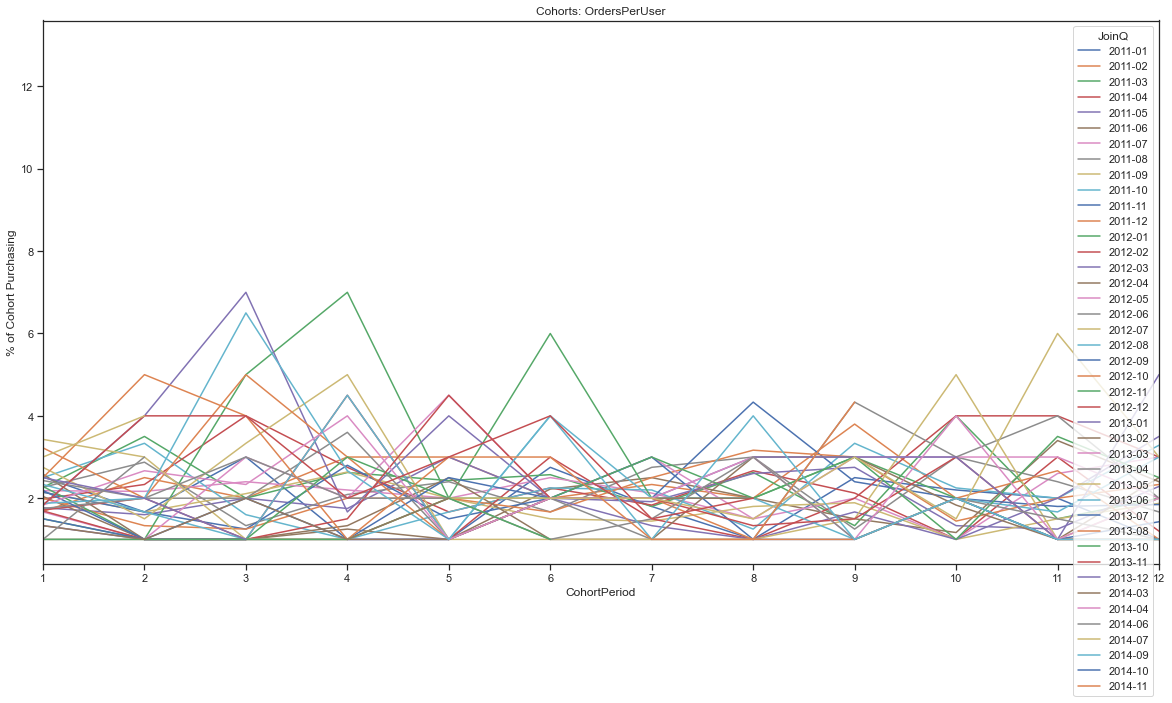

In [38]:
import seaborn as sns
sns.set(style='ticks')
plt.figure(figsize=(24, 16))
plt.title('Cohorts: User Retention')
sns.heatmap(user_retention.T, mask=user_retention.T.isnull(), annot=True, fmt='.00%');




## Расчитаем частоту покупок по когортам
c = cohorts['TotalOrders']/cohorts['TotalUsers']
opc = c.unstack(0)

opc[['2011-01',
 '2011-02',
 '2011-03',
 '2011-04',
 '2011-05',
 '2011-06',
 '2011-07',
 '2011-08',
 '2011-09',
 '2011-10',
 '2011-11',
 '2011-12',
 '2012-01',
 '2012-02',
 '2012-03',
 '2012-04',
 '2012-05',
 '2012-06',
 '2012-07',
 '2012-08',
 '2012-09',
 '2012-10',
 '2012-11',
 '2012-12',
 '2013-01',
 '2013-02',
 '2013-03',
 '2013-04',
 '2013-05',
 '2013-06',
 '2013-07',
 '2013-08',
 '2013-10',
 '2013-11',
 '2013-12',
 '2014-03',
 '2014-04',
 '2014-06',
 '2014-07',
 '2014-09',
 '2014-10',
 '2014-11']].plot(figsize=(20,10))
plt.title('Cohorts: OrdersPerUser')
plt.xticks(np.arange(1, 12.1, 1)) # разбивка оси X
plt.xlim(1, 12) #ось X
plt.ylabel('% of Cohort Purchasing');


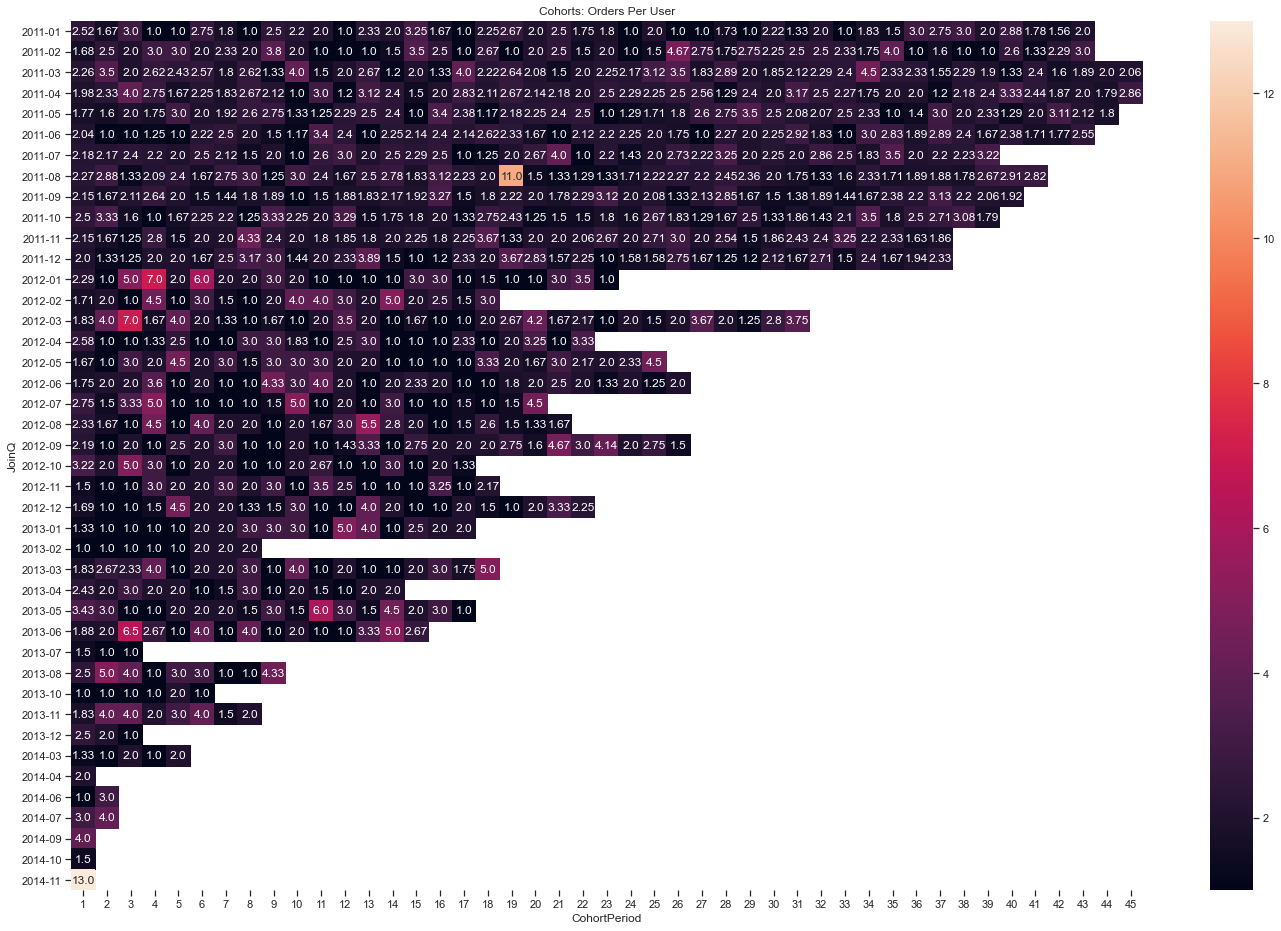

In [39]:
import seaborn as sns
sns.set(style='ticks')
plt.figure(figsize=(24, 16))
plt.title('Cohorts: Orders Per User')
sns.heatmap(opc.T, mask=opc.T.isnull(), annot=True, fmt='.3');

# FORECAST

In [166]:
import numpy as np
import pandas as pd
import pandahouse as ph
from datetime import date
import holidays
from fbprophet import Prophet

In [167]:
df1 = pd.read_excel('Superstore.xlsx')

In [168]:
df = df1[['OrderDate', 'Sales']]

In [169]:
df

,OrderDate,Sales
0,2013-11-09,261.9600
1,2013-11-09,731.9400
2,2013-06-13,14.6200
3,2012-10-11,957.5775
4,2012-10-11,22.3680
...,...,...
9989,2011-01-22,25.2480
9990,2014-02-27,91.9600
9991,2014-02-27,258.5760
9992,2014-02-27,29.6000


In [170]:
df = df.rename(columns={'OrderDate': 'ds', 'Sales': 'y'})
df

,ds,y
0,2013-11-09,261.9600
1,2013-11-09,731.9400
2,2013-06-13,14.6200
3,2012-10-11,957.5775
4,2012-10-11,22.3680
...,...,...
9989,2011-01-22,25.2480
9990,2014-02-27,91.9600
9991,2014-02-27,258.5760
9992,2014-02-27,29.6000


In [171]:
df = df.groupby('ds', as_index = False)['y'].sum()

In [172]:
df = pd.DataFrame(df)

In [173]:
df

,ds,y
0,2011-01-04,16.4480
1,2011-01-05,288.0600
2,2011-01-06,19.5360
3,2011-01-07,4407.1000
4,2011-01-08,87.1580
...,...,...
1233,2014-12-27,814.5940
1234,2014-12-28,177.6360
1235,2014-12-29,1657.3508
1236,2014-12-30,2915.5340


In [174]:
# Вкидываем праздники, для их учёта моделькой
holidays_dict = holidays.US(years=(2011, 2012, 2013, 2014))
df_holidays = pd.DataFrame.from_dict(holidays_dict, orient='index') \
    .reset_index()
df_holidays = df_holidays.rename({'index':'ds', 0:'holiday'}, axis ='columns')
df_holidays['ds'] = pd.to_datetime(df_holidays.ds)
df_holidays = df_holidays.sort_values(by=['ds'])
df_holidays = df_holidays.reset_index(drop=True)
df_holidays

,ds,holiday
0,2010-12-31,New Year's Day (Observed)
1,2011-01-01,New Year's Day
2,2011-01-17,Martin Luther King Jr. Day
3,2011-02-21,Washington's Birthday
4,2011-05-30,Memorial Day
5,2011-07-04,Independence Day
6,2011-09-05,Labor Day
7,2011-10-10,Columbus Day
8,2011-11-11,Veterans Day
9,2011-11-24,Thanksgiving


In [188]:
# Период, который надо отрезать и предсказать (проверка модели)
predictions = 360

# Отрезаем из обучающей выборки последние N точек, чтобы измерить на них качество
train_df = df[:-predictions]

In [189]:
# Настраиваем prophet – говорим ему учитывать праздники и сезонности
m = Prophet(holidays=df_holidays, daily_seasonality=False, weekly_seasonality=False, yearly_seasonality=True, 
            #n_changepoints=8
            #changepoint_range=0.9,
            #changepoint_prior_scale=0.25,
             #       seasonality_mode='multiplicative'
           )
m.fit(train_df)

In [190]:
# Предсказываем 360 дн
future = m.make_future_dataframe(periods=predictions)
forecast = m.predict(future)

In [191]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas Day,Christmas Day_lower,Christmas Day_upper,Christmas Day (Observed),Christmas Day (Observed)_lower,Christmas Day (Observed)_upper,Columbus Day,Columbus Day_lower,Columbus Day_upper,Independence Day,Independence Day_lower,Independence Day_upper,Labor Day,Labor Day_lower,Labor Day_upper,Martin Luther King Jr. Day,Martin Luther King Jr. Day_lower,Martin Luther King Jr. Day_upper,Memorial Day,...,Thanksgiving,Thanksgiving_lower,Thanksgiving_upper,Veterans Day,Veterans Day_lower,Veterans Day_upper,Veterans Day (Observed),Veterans Day (Observed)_lower,Veterans Day (Observed)_upper,Washington's Birthday,Washington's Birthday_lower,Washington's Birthday_upper,additive_terms,additive_terms_lower,additive_terms_upper,holidays,holidays_lower,holidays_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2011-01-04,1438.478926,-1848.486416,3629.423938,1438.478926,1438.478926,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-339.930280,-339.930280,-339.930280,0.0,0.0,0.0,-339.930280,-339.930280,-339.930280,0.0,0.0,0.0,1098.548646
1,2011-01-05,1438.903385,-1768.526247,3384.204405,1438.903385,1438.903385,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-477.208014,-477.208014,-477.208014,0.0,0.0,0.0,-477.208014,-477.208014,-477.208014,0.0,0.0,0.0,961.695371
2,2011-01-06,1439.327844,-1860.738536,3579.718901,1439.327844,1439.327844,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-606.321662,-606.321662,-606.321662,0.0,0.0,0.0,-606.321662,-606.321662,-606.321662,0.0,0.0,0.0,833.006182
3,2011-01-07,1439.752303,-1859.248263,3372.497241,1439.752303,1439.752303,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-725.037906,-725.037906,-725.037906,0.0,0.0,0.0,-725.037906,-725.037906,-725.037906,0.0,0.0,0.0,714.714397
4,2011-01-08,1440.176763,-2036.020998,3057.446709,1440.176763,1440.176763,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-831.359584,-831.359584,-831.359584,0.0,0.0,0.0,-831.359584,-831.359584,-831.359584,0.0,0.0,0.0,608.817179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1233,2014-11-12,1894.617323,794.836265,5945.194929,1890.167032,1899.105488,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1401.817555,1401.817555,1401.817555,0.0,0.0,0.0,1401.817555,1401.817555,1401.817555,0.0,0.0,0.0,3296.434878
1234,2014-11-13,1894.935550,504.312231,5887.506890,1890.475902,1899.451342,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1404.993406,1404.993406,1404.993406,0.0,0.0,0.0,1404.993406,1404.993406,1404.993406,0.0,0.0,0.0,3299.928956
1235,2014-11-14,1895.253777,814.425399,5968.608621,1890.784772,1899.786658,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1394.876760,1394.876760,1394.876760,0.0,0.0,0.0,1394.876760,1394.876760,1394.876760,0.0,0.0,0.0,3290.130538
1236,2014-11-15,1895.572004,652.879117,5926.244993,1891.087220,1900.121973,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1371.911770,1371.911770,1371.911770,0.0,0.0,0.0,1371.911770,1371.911770,1371.911770,0.0,0.0,0.0,3267.483774


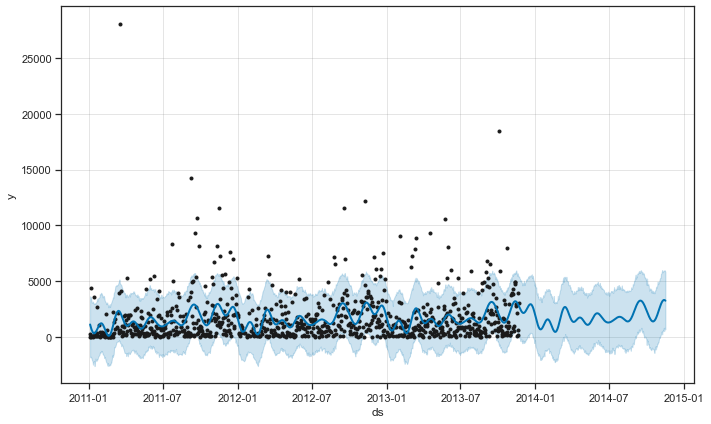

In [192]:
# Смотрим, что предсказалось
m.plot(forecast);

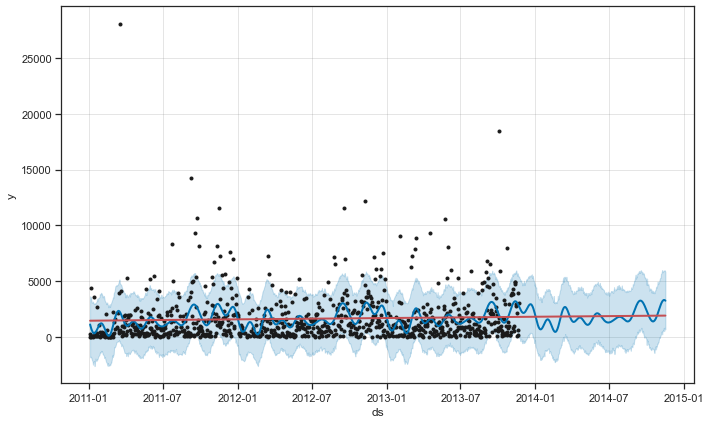

In [193]:
from fbprophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)


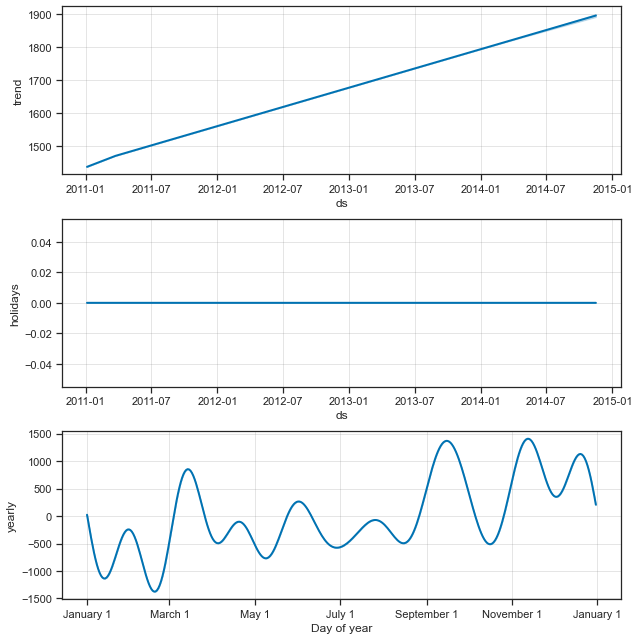

In [194]:
# Смотрим на сезонности
m.plot_components(forecast);

In [195]:
# Рисуем график с границами прогноза
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected = True)

iplot([
    go.Scatter(x=df['ds'], y=df['y'], name='fact'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='prediction'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat_upper'], fill='tonexty', mode='none', name='upper'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat_lower'], fill='tonexty', mode='none', name='lower'),
    go.Scatter(x=forecast['ds'], y=forecast['trend'], name='trend')
])

In [196]:
# Смотрим на ошибки модели
cmp_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df.set_index('ds'))
cmp_df['e'] = cmp_df['y'] - cmp_df['yhat']
cmp_df['p'] = 100*cmp_df['e']/cmp_df['y']
print('MAPE (средняя абсолютная ошибка в процентах) – ', np.mean(abs(cmp_df[-predictions:]['p'])),'%')
print('MAE (средняя абсолютная ошибка) – ', np.mean(abs(cmp_df[-predictions:]['e'])))

MAPE (средняя абсолютная ошибка в процентах) –  534.4081000282441 %
MAE (средняя абсолютная ошибка) –  1656.912001550886


In [197]:
# Прогнозируем на полный период (указываем количество дней)
prediction_days = 360
final_train_df = df
f = Prophet(holidays=df_holidays, daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=True)
f.fit(final_train_df)
final_future = f.make_future_dataframe(periods=prediction_days)
final_forecast = f.predict(final_future)

In [198]:
final_forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas Day,Christmas Day_lower,Christmas Day_upper,Christmas Day (Observed),Christmas Day (Observed)_lower,Christmas Day (Observed)_upper,Columbus Day,Columbus Day_lower,Columbus Day_upper,Independence Day,Independence Day_lower,Independence Day_upper,Labor Day,Labor Day_lower,Labor Day_upper,Martin Luther King Jr. Day,Martin Luther King Jr. Day_lower,Martin Luther King Jr. Day_upper,Memorial Day,...,Veterans Day,Veterans Day_lower,Veterans Day_upper,Veterans Day (Observed),Veterans Day (Observed)_lower,Veterans Day (Observed)_upper,Washington's Birthday,Washington's Birthday_lower,Washington's Birthday_upper,additive_terms,additive_terms_lower,additive_terms_upper,holidays,holidays_lower,holidays_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2011-01-04,1266.454009,-1457.359102,3792.505044,1266.454009,1266.454009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49.150717,49.150717,49.150717,0.0,0.0,0.0,425.751879,425.751879,425.751879,-376.601162,-376.601162,-376.601162,0.0,0.0,0.0,1315.604727
1,2011-01-05,1266.732562,-1961.981232,3310.669149,1266.732562,1266.732562,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-425.785580,-425.785580,-425.785580,0.0,0.0,0.0,47.840701,47.840701,47.840701,-473.626281,-473.626281,-473.626281,0.0,0.0,0.0,840.946983
2,2011-01-06,1267.011115,-1577.701535,3903.644245,1267.011115,1267.011115,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-138.107142,-138.107142,-138.107142,0.0,0.0,0.0,425.374691,425.374691,425.374691,-563.481834,-563.481834,-563.481834,0.0,0.0,0.0,1128.903973
3,2011-01-07,1267.289668,-1580.868126,3823.195795,1267.289668,1267.289668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-46.107508,-46.107508,-46.107508,0.0,0.0,0.0,598.881109,598.881109,598.881109,-644.988617,-644.988617,-644.988617,0.0,0.0,0.0,1221.182160
4,2011-01-08,1267.568221,-2680.369373,2759.749032,1267.568221,1267.568221,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1146.007558,-1146.007558,-1146.007558,0.0,0.0,0.0,-428.879767,-428.879767,-428.879767,-717.127791,-717.127791,-717.127791,0.0,0.0,0.0,121.560662
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1593,2015-12-22,2613.948028,1194.831563,6711.192333,2588.480399,2640.701975,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1342.276073,1342.276073,1342.276073,0.0,0.0,0.0,425.751879,425.751879,425.751879,916.524194,916.524194,916.524194,0.0,0.0,0.0,3956.224101
1594,2015-12-23,2614.955321,712.374380,6194.474041,2589.370795,2641.842851,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,899.876729,899.876729,899.876729,0.0,0.0,0.0,47.840701,47.840701,47.840701,852.036028,852.036028,852.036028,0.0,0.0,0.0,3514.832050
1595,2015-12-24,2615.962614,1117.665513,6400.729405,2590.261190,2642.957117,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1204.200630,1204.200630,1204.200630,0.0,0.0,0.0,425.374691,425.374691,425.374691,778.825939,778.825939,778.825939,0.0,0.0,0.0,3820.163244
1596,2015-12-25,2616.969907,1146.556189,6655.217617,2591.151585,2644.051876,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1296.232818,1296.232818,1296.232818,0.0,0.0,0.0,598.

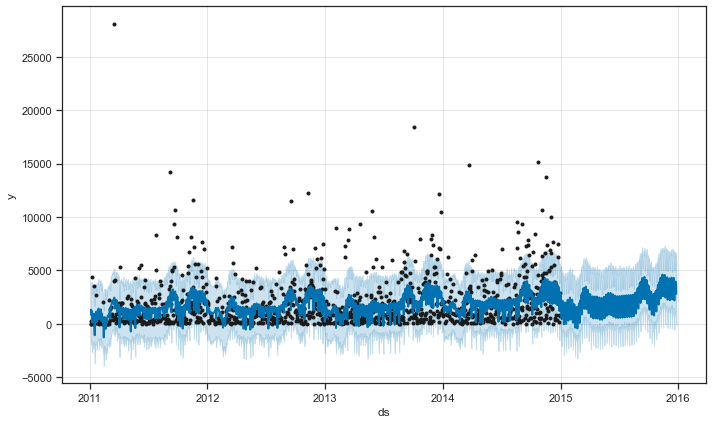

In [199]:
# Смотрим, что предсказалось на полный период
f.plot(final_forecast);

In [200]:
# Рисуем график с границами прогноза на полном периоде
iplot([
    go.Scatter(x=df['ds'], y=df['y'], name='fact'),
    go.Scatter(x=final_forecast['ds'], y=final_forecast['yhat'], name='yhat'),
    go.Scatter(x=final_forecast['ds'], y=final_forecast['yhat_upper'], fill='tonexty', mode='none', name='upper'),
    go.Scatter(x=final_forecast['ds'], y=final_forecast['yhat_lower'], fill='tonexty', mode='none', name='lower'),
    go.Scatter(x=final_forecast['ds'], y=final_forecast['trend'], name='trend')
])